In [1]:
import pandas as pd
import numpy as np
import os
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


from resources.constants import *

pictures_df = pd.read_csv(PICTURE_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)
outfits_df = pd.read_csv(OUTFITS_CSV_PATH, sep=CSV_SEPARATOR)
user_triplets_df = pd.read_csv(USER_ACTIVITY_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)

c:\Users\kaborg15\Python_projects\Vibrent_Dataset_Collection


In [2]:
# CSV files are read as strings, so we need to convert them to lists
outfits_df["tag_categories"] = outfits_df["tag_categories"].apply(eval)
outfits_df["outfit_tags"] = outfits_df["outfit_tags"].apply(eval)

In [3]:
id_group_dict = outfits_df[["id", "group"]].to_dict(orient="records")
id_group_dict = {x["id"]: x["group"] for x in id_group_dict}

user_triplets_df["group"] = user_triplets_df["outfit.id"].map(id_group_dict)
user_triplets_df

,customer.id,outfit.id,meta.validFrom,derived.bookingTime,group
0,969,outfit.5c081909537b42239e465d2d615c705f,2023-04-27 12:46:35.184,2023-03-19 14:24:09.539,group.79d7302719c9325ecb7a4a140fb25ca1
1,209,outfit.c34969dd8b334064aa90bfb60c8ec308,2023-05-05 09:44:38.200,2023-01-17 13:36:53.371,group.8625d8e9c5b8da9b4793dd636ac9afc9
2,209,outfit.aef4cc93eebf40ca8820790deb7a8323,2023-05-05 09:44:38.200,2023-01-17 13:36:53.371,group.f006b0dd53fdf64104db43f9c8dfe872
3,2235,outfit.3de5df48a14b4a9aba6d8e41d11e9351,2022-11-22 03:04:56.144,2021-10-04 10:00:17.854,group.3222ea830704958953d7f63097e88143
4,2235,outfit.0eaa358af14e469894062591bd42f38b,2022-11-22 03:04:56.144,2021-10-04 10:00:17.854,group.702a9964f42e5d231868610b9ed1422a
...,...,...,...,...,...
64165,1426,outfit.5bedabce07614c608b03fbb369d9abe7,2022-11-22 13:11:49.877,2021-07-10 08:09:49.250,group.34598adaf25b5b74f05e182257329ec0
64166,358,outfit.bb35c791b2bfa191,2021-05-28 11:41:48.526,2021-04-19 06:52:08.332,group.8cd6c26aaa386a01ba422c0f47bf9a1e
64167,358,outfit.ad6f853b5c31b6f5,2021-05-28 11:41:48.526,2021-04-19 06:52:08.332,group.793eca0e71eafbf27c6f0bddad69e593
64168,1629,outfit.73393583c562454cbf1c00ce3cac0862,2023-11-25 07:48:26.991,2023-11-21 13:27:25.349,group.f75720d7b914feb2e6fabead7c3b3525


In [4]:
user_orders_df = user_triplets_df.groupby("customer.id").agg({"outfit.id": list, "group":list, "meta.validFrom":list, "derived.bookingTime":list}).reset_index()
user_orders_df["num_orders"] = user_orders_df["outfit.id"].apply(lambda x: len(x))
user_orders_df = user_orders_df[user_orders_df["num_orders"] > 1]
user_orders_df["num_orders"].describe()

count    2216.000000
mean       28.942690
std        41.905773
min         2.000000
25%         5.000000
50%        13.000000
75%        35.000000
max       356.000000
Name: num_orders, dtype: float64

In [9]:
import numpy as np
from src.prepare_train_test_splits import convert_user_orders_to_train_test_splits

user_splits_df, user_splits_unique_df = convert_user_orders_to_train_test_splits(user_orders_df, percentage_test=0.3)

No unique outfit found with groups ['group.8abe6af9eccc8b578c2ef59628f8b454'
 'group.96f4cce22d4a236e0652c67fc9b18d12'
 'group.8abe6af9eccc8b578c2ef59628f8b454'
 'group.96f4cce22d4a236e0652c67fc9b18d12']


In [17]:
import pandas as pd
import implicit
from scipy.sparse import coo_matrix
from IPython.display import display
from itertools import product


from src.evaluate_models import evaluate_model, evaluate_hit_rate_at_n, get_outfit_id_from_index

def train_als_model(user_splits_df, outfit_column, factors=16, regularization=0.1, iterations=50):
    flat_df = user_splits_df.explode(outfit_column)
    flat_df["value"] = 1
    
    unique_outfit_ids = flat_df[outfit_column].unique()
    outfit_to_index = {outfit_id: i for i, outfit_id in enumerate(unique_outfit_ids)}
    flat_df["outfit_index"] = flat_df[outfit_column].map(outfit_to_index)
    
    unique_users = pd.unique(flat_df.index)
    user_to_index = {user_id: i for i, user_id in enumerate(unique_users)}
    flat_df['user_index'] = flat_df.index.map(user_to_index)
    
    # Debug: Check if there are any negative indices
    if (flat_df['outfit_index'] < 0).any():
        raise ValueError('Negative outfit_index found')
    if (flat_df['user_index'] < 0).any():
        raise ValueError('Negative user_index found')

    coo = coo_matrix(
        (flat_df['value'].values, (flat_df['user_index'].values, flat_df['outfit_index'].values)),
        shape=(len(unique_users), len(unique_outfit_ids))
    )
    
    np.random.seed(42)
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations, )
    csr = coo.tocsr()
    model.fit(csr)

    return model, csr, outfit_to_index, user_to_index

def run_als_training_loop(df, factors, regularization, run_name=""):
    model_ind, csr_ind, outfit_id_to_index, user_to_index = train_als_model(df, "train_outfit_ids", factors=factors, regularization=regularization)
    model_group, csr_group, outfit_group_to_index, _ = train_als_model(df, "train_group", factors=factors, regularization=regularization)

    df["user_index"] = df.index.map(user_to_index)

    ind_index_to_id = {value : key for key, value in outfit_id_to_index.items()}
    df["ind_recommendations"] = df.apply(lambda x: evaluate_model(model_ind, csr_ind, x["user_index"], n=100), axis=1)
    df["ind_recommendations"] = df.apply(lambda x: get_outfit_id_from_index(x["ind_recommendations"], ind_index_to_id), axis=1)

    group_index_to_id = {value : key for key, value in outfit_group_to_index.items()}
    df["group_recommendations"] = df.apply(lambda x: evaluate_model(model_group, csr_group, x["user_index"], n=100), axis=1)
    df["group_recommendations"] = df.apply(lambda x: get_outfit_id_from_index(x["group_recommendations"], group_index_to_id), axis=1)

    HIT_RATE_COLUMNS = ["id_hit_rate_at_100", "id_hit_rate_at_10", "group_hit_rate_at_100", "group_hit_rate_at_10"]
    df["id_hit_rate_at_100"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_outfit_id"], x["ind_recommendations"], n=100), axis=1)
    df["id_hit_rate_at_10"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_outfit_id"], x["ind_recommendations"], n=10), axis=1)
    df["group_hit_rate_at_100"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_group"], x["group_recommendations"], n=100), axis=1)
    df["group_hit_rate_at_10"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_group"], x["group_recommendations"], n=10), axis=1)

    print(f"Run name: {run_name} Factors: {factors}, Regularization: {regularization}")
    display(df[HIT_RATE_COLUMNS].mean())
    print("="*20)

    result_dict = {column: df[column].mean() for column in HIT_RATE_COLUMNS}

    return df, (factors, regularization, df["group_hit_rate_at_100"].mean(), run_name), result_dict
    


TEST_FACTORS = [32]
TEST_REGULARIZATIONS = [0.01]
run_dataframes = [(user_splits_df, "All Outfits"), (user_splits_unique_df, "Unique Outfit")]

test_permutations = list(product(TEST_FACTORS, TEST_REGULARIZATIONS))
test_permutations = [(t_factors, t_reg, run_df) for t_factors, t_reg, run_df in product(TEST_FACTORS, TEST_REGULARIZATIONS, run_dataframes)]

group_hr_10_means, result_dicts = [], []
for test_factors, test_regularization, (df, run_name) in test_permutations:
    df, result, result_dict = run_als_training_loop(df, test_factors, test_regularization, run_name=run_name)
    result_dicts.append(result_dict)
    group_hr_10_means.append(result)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Run name: All Outfits Factors: 32, Regularization: 0.01


id_hit_rate_at_100       0.232401
id_hit_rate_at_10        0.046931
group_hit_rate_at_100    0.355596
group_hit_rate_at_10     0.085740
dtype: float64

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Run name: Unique Outfit Factors: 32, Regularization: 0.01


id_hit_rate_at_100       0.256885
id_hit_rate_at_10        0.061851
group_hit_rate_at_100    0.358916
group_hit_rate_at_10     0.108352
dtype: float64

In [19]:
import pyperclip

def format_dicts_into_latex(all_dict, ind_dict, precision=4):
    first_row = f"ALS Ind & {all_dict['id_hit_rate_at_10']:.{precision}f} & {all_dict['id_hit_rate_at_100']:.{precision}f} & {ind_dict['id_hit_rate_at_10']:.{precision}f} & {ind_dict['id_hit_rate_at_100']:.{precision}f} \\\\"
    second_row = f"ALS Groupd & {all_dict['group_hit_rate_at_10']:.{precision}f} & {all_dict['group_hit_rate_at_100']:.{precision}f} & {ind_dict['group_hit_rate_at_10']:.{precision}f} & {ind_dict['group_hit_rate_at_100']:.{precision}f} \\\\\\hline"
    full_string = first_row + "\n" + second_row + "\n"
    print(full_string)
    pyperclip.copy(full_string)

all_dict, ind_dict = result_dicts
format_dicts_into_latex(all_dict, ind_dict, precision=4)

ALS Ind & 0.0469 & 0.2324 & 0.0619 & 0.2569 \\
ALS Groupd & 0.0857 & 0.3556 & 0.1084 & 0.3589 \\\hline



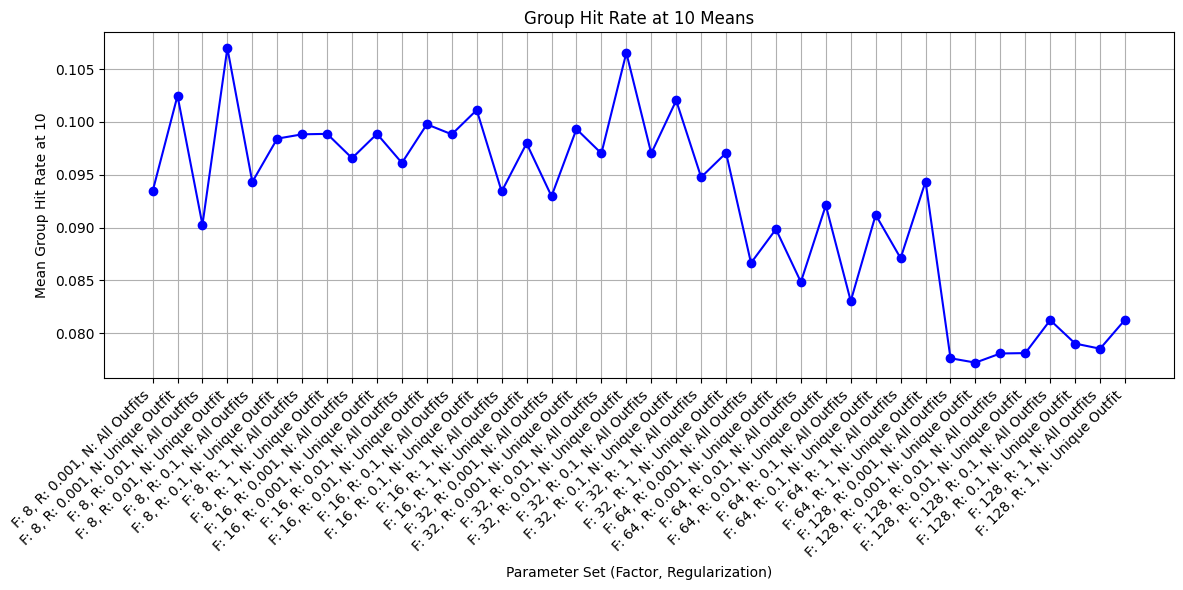

In [9]:
import matplotlib.pyplot as plt

mean_values = [entry[2] for entry in group_hr_10_means]
labels = [f'F: {entry[0]}, R: {entry[1]}, N: {entry[3]}' for entry in group_hr_10_means]

plt.figure(figsize=(12, 6))
plt.plot(mean_values, marker='o', linestyle='-', color='b')
plt.title('Group Hit Rate at 10 Means')
plt.xlabel('Parameter Set (Factor, Regularization)')
plt.ylabel('Mean Group Hit Rate at 10')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
import implicit
from scipy.sparse import coo_matrix
from IPython.display import display
from itertools import product

from implicit.bpr import BayesianPersonalizedRanking


def train_bpr_model(user_splits_df, outfit_column, factors=16, regularization=0.1, learning_rate=0.1, iterations=500):
    flat_df = user_splits_df.explode(outfit_column)
    flat_df["value"] = 1
    
    unique_outfit_ids = flat_df[outfit_column].unique()
    outfit_to_index = {outfit_id: i for i, outfit_id in enumerate(unique_outfit_ids)}
    flat_df["outfit_index"] = flat_df[outfit_column].map(outfit_to_index)
    
    unique_users = pd.unique(flat_df.index)
    user_to_index = {user_id: i for i, user_id in enumerate(unique_users)}
    flat_df['user_index'] = flat_df.index.map(user_to_index)
    
    # Debug: Check if there are any negative indices
    if (flat_df['outfit_index'] < 0).any():
        raise ValueError('Negative outfit_index found')
    if (flat_df['user_index'] < 0).any():
        raise ValueError('Negative user_index found')

    coo = coo_matrix(
        (flat_df['value'].values, (flat_df['user_index'].values, flat_df['outfit_index'].values)),
        shape=(len(unique_users), len(unique_outfit_ids))
    )
    
    np.random.seed(43)
    model = BayesianPersonalizedRanking(factors=factors, regularization=regularization, iterations=iterations, learning_rate=learning_rate)
    csr = coo.tocsr()
    model.fit(csr)
    
    return model, csr, outfit_to_index, user_to_index


def run_bpr_training_loop(df, factors, regularization, learning_rate, run_name=""):
    model_ind, csr_ind, outfit_id_to_index, user_to_index = train_bpr_model(df, "train_outfit_ids", factors=factors, regularization=regularization, learning_rate=learning_rate)
    model_group, csr_group, outfit_group_to_index, _ = train_bpr_model(df, "train_group", factors=factors, regularization=regularization, learning_rate=learning_rate)

    df["user_index"] = df.index.map(user_to_index)

    ind_index_to_id = {value : key for key, value in outfit_id_to_index.items()}
    df["ind_recommendations"] = df.apply(lambda x: evaluate_model(model_ind, csr_ind, x["user_index"], n=100), axis=1)
    df["ind_recommendations"] = df.apply(lambda x: get_outfit_id_from_index(x["ind_recommendations"], ind_index_to_id), axis=1)

    group_index_to_id = {value : key for key, value in outfit_group_to_index.items()}
    df["group_recommendations"] = df.apply(lambda x: evaluate_model(model_group, csr_group, x["user_index"], n=100), axis=1)
    df["group_recommendations"] = df.apply(lambda x: get_outfit_id_from_index(x["group_recommendations"], group_index_to_id), axis=1)

    HIT_RATE_COLUMNS = ["id_hit_rate_at_100", "id_hit_rate_at_10", "group_hit_rate_at_100", "group_hit_rate_at_10"]
    df["id_hit_rate_at_100"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_outfit_id"], x["ind_recommendations"], n=100), axis=1)
    df["id_hit_rate_at_10"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_outfit_id"], x["ind_recommendations"], n=10), axis=1)
    df["group_hit_rate_at_100"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_group"], x["group_recommendations"], n=100), axis=1)
    df["group_hit_rate_at_10"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_group"], x["group_recommendations"], n=10), axis=1)

    print(f"Run name: {run_name} Factors: {factors}, Regularization: {regularization}")
    display(df[HIT_RATE_COLUMNS].mean())
    print("="*20)

    result_dict = {column: df[column].mean() for column in HIT_RATE_COLUMNS}

    return df, (factors, regularization, df["group_hit_rate_at_100"].mean(), df["id_hit_rate_at_100"].mean(), run_name), result_dict


TEST_FACTORS = [128]
TEST_REGULARIZATIONS = [0.01]
TEST_LEARNING_RATES = [0.01]
#run_dataframes = [user_splits_df]
run_dataframes = [(user_splits_df, "All Outfits"), (user_splits_unique_df, "Unique Outfit")]

test_permutations = list(product(TEST_FACTORS, TEST_REGULARIZATIONS, TEST_LEARNING_RATES))
test_permutations = [(t_factors, t_reg, t_lr, run_df) for t_factors, t_reg, t_lr, run_df in product(TEST_FACTORS, TEST_REGULARIZATIONS, TEST_LEARNING_RATES, run_dataframes)]

group_hr_10_means, result_dicts = [], []
for test_factors, test_regularization, test_learning_rate, (df, run_name) in test_permutations:
    df, result, result_dict = run_bpr_training_loop(df, test_factors, test_regularization, test_learning_rate, run_name=run_name)
    result_dicts.append(result_dict)
    group_hr_10_means.append(result)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Run name: All Outfits Factors: 128, Regularization: 0.01


id_hit_rate_at_100       0.268502
id_hit_rate_at_10        0.058213
group_hit_rate_at_100    0.305054
group_hit_rate_at_10     0.060921
dtype: float64

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Run name: Unique Outfit Factors: 128, Regularization: 0.01


id_hit_rate_at_100       0.291196
id_hit_rate_at_10        0.065011
group_hit_rate_at_100    0.334537
group_hit_rate_at_10     0.083521
dtype: float64

In [21]:
import pyperclip

def format_dicts_into_latex(all_dict, ind_dict, precision=4):
    first_row = f"BPR Ind & {all_dict['id_hit_rate_at_10']:.{precision}f} & {all_dict['id_hit_rate_at_100']:.{precision}f} & {ind_dict['id_hit_rate_at_10']:.{precision}f} & {ind_dict['id_hit_rate_at_100']:.{precision}f} \\\\"
    second_row = f"BPR Groups & {all_dict['group_hit_rate_at_10']:.{precision}f} & {all_dict['group_hit_rate_at_100']:.{precision}f} & {ind_dict['group_hit_rate_at_10']:.{precision}f} & {ind_dict['group_hit_rate_at_100']:.{precision}f} \\\\\\hline"
    full_string = first_row + "\n" + second_row + "\n"
    print(full_string)
    pyperclip.copy(full_string)

all_dict, ind_dict = result_dicts
format_dicts_into_latex(all_dict, ind_dict, precision=4)

BPR Ind & 0.0582 & 0.2685 & 0.0650 & 0.2912 \\
BPR Groups & 0.0609 & 0.3051 & 0.0835 & 0.3345 \\\hline



In [26]:
import pandas as pd
import implicit
from scipy.sparse import coo_matrix
from IPython.display import display
from itertools import product

from implicit.lmf import LogisticMatrixFactorization

def train_lmf_model(user_splits_df, outfit_column, factors=16, regularization=0.1, learning_rate=0.1, iterations=500):
    flat_df = user_splits_df.explode(outfit_column)
    flat_df["value"] = 1
    
    unique_outfit_ids = flat_df[outfit_column].unique()
    outfit_to_index = {outfit_id: i for i, outfit_id in enumerate(unique_outfit_ids)}
    flat_df["outfit_index"] = flat_df[outfit_column].map(outfit_to_index)
    
    unique_users = pd.unique(flat_df.index)
    user_to_index = {user_id: i for i, user_id in enumerate(unique_users)}
    flat_df['user_index'] = flat_df.index.map(user_to_index)
    
    # Debug: Check if there are any negative indices
    if (flat_df['outfit_index'] < 0).any():
        raise ValueError('Negative outfit_index found')
    if (flat_df['user_index'] < 0).any():
        raise ValueError('Negative user_index found')

    coo = coo_matrix(
        (flat_df['value'].values, (flat_df['user_index'].values, flat_df['outfit_index'].values)),
        shape=(len(unique_users), len(unique_outfit_ids))
    )
    
    np.random.seed(43)
    model = LogisticMatrixFactorization(factors=factors, regularization=regularization, iterations=iterations, learning_rate=learning_rate)
    csr = coo.tocsr()
    model.fit(csr)
    
    return model, csr, outfit_to_index, user_to_index

def run_lmf_training_loop(df, factors, regularization, learning_rate, run_name=""):
    model_ind, csr_ind, outfit_id_to_index, user_to_index = train_lmf_model(df, "train_outfit_ids", factors=factors, regularization=regularization, learning_rate=learning_rate)
    model_group, csr_group, outfit_group_to_index, _ = train_lmf_model(df, "train_group", factors=factors, regularization=regularization, learning_rate=learning_rate)

    df["user_index"] = df.index.map(user_to_index)

    ind_index_to_id = {value : key for key, value in outfit_id_to_index.items()}
    df["ind_recommendations"] = df.apply(lambda x: evaluate_model(model_ind, csr_ind, x["user_index"], n=100), axis=1)
    df["ind_recommendations"] = df.apply(lambda x: get_outfit_id_from_index(x["ind_recommendations"], ind_index_to_id), axis=1)

    group_index_to_id = {value : key for key, value in outfit_group_to_index.items()}
    df["group_recommendations"] = df.apply(lambda x: evaluate_model(model_group, csr_group, x["user_index"], n=100), axis=1)
    df["group_recommendations"] = df.apply(lambda x: get_outfit_id_from_index(x["group_recommendations"], group_index_to_id), axis=1)

    HIT_RATE_COLUMNS = ["id_hit_rate_at_100", "id_hit_rate_at_10", "group_hit_rate_at_100", "group_hit_rate_at_10"]
    df["id_hit_rate_at_100"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_outfit_id"], x["ind_recommendations"], n=100), axis=1)
    df["id_hit_rate_at_10"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_outfit_id"], x["ind_recommendations"], n=10), axis=1)
    df["group_hit_rate_at_100"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_group"], x["group_recommendations"], n=100), axis=1)
    df["group_hit_rate_at_10"] = df.apply(lambda x: evaluate_hit_rate_at_n(x["test_group"], x["group_recommendations"], n=10), axis=1)

    print(f"Run name: {run_name} Factors: {factors}, Regularization: {regularization}")
    display(df[HIT_RATE_COLUMNS].mean())
    print("="*20)

    result_dict = {column: df[column].mean() for column in HIT_RATE_COLUMNS}

    return df, (factors, regularization, df["group_hit_rate_at_10"].mean(), df["id_hit_rate_at_10"].mean(), run_name), result_dict


TEST_FACTORS = [128]
TEST_REGULARIZATIONS = [0.01]
TEST_LEARNING_RATES = [0.01]
#run_dataframes = [user_splits_df]
run_dataframes = [(user_splits_df, "All Outfits"), (user_splits_unique_df, "Unique Outfit")]

test_permutations = list(product(TEST_FACTORS, TEST_REGULARIZATIONS, TEST_LEARNING_RATES))
test_permutations = [(t_factors, t_reg, t_lr, run_df) for t_factors, t_reg, t_lr, run_df in product(TEST_FACTORS, TEST_REGULARIZATIONS, TEST_LEARNING_RATES, run_dataframes)]

group_hr_10_means, result_dicts = [], []
for test_factors, test_regularization, test_learning_rate, (df, run_name) in test_permutations:
    df, result, result_dict = run_lmf_training_loop(df, test_factors, test_regularization, test_learning_rate, run_name=run_name)
    result_dicts.append(result_dict)
    group_hr_10_means.append(result)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Run name: All Outfits Factors: 128, Regularization: 0.01


id_hit_rate_at_100       0.010379
id_hit_rate_at_10        0.001354
group_hit_rate_at_100    0.007671
group_hit_rate_at_10     0.000451
dtype: float64

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Run name: Unique Outfit Factors: 128, Regularization: 0.01


id_hit_rate_at_100       0.007675
id_hit_rate_at_10        0.001354
group_hit_rate_at_100    0.010384
group_hit_rate_at_10     0.000903
dtype: float64

In [29]:
def format_dicts_into_latex(all_dict, ind_dict, precision=4):
    first_row = f"BPR Ind: & {all_dict['id_hit_rate_at_10']:.{precision}f} & {all_dict['id_hit_rate_at_100']:.{precision}f} & {ind_dict['id_hit_rate_at_10']:.{precision}f} & {ind_dict['id_hit_rate_at_100']:.{precision}f} \\\\"
    second_row = f"BPR Groupd: & {all_dict['group_hit_rate_at_10']:.{precision}f} & {all_dict['group_hit_rate_at_100']:.{precision}f} & {ind_dict['group_hit_rate_at_10']:.{precision}f} & {ind_dict['group_hit_rate_at_100']:.{precision}f} \\\\\\hline"
    print(first_row)
    print(second_row)

all_dict, ind_dict = result_dicts
format_dicts_into_latex(all_dict, ind_dict, precision=4)

BPR Ind: & 0.0014 & 0.0104 & 0.0014 & 0.0077 \\
BPR Groupd: & 0.0005 & 0.0077 & 0.0009 & 0.0104 \\\hline
